# Speed Test: Cumulonumba (rough initial implementation) vs. MetPy

*Very* preliminary results

In [1]:
import awkward as ak
import numba
import numpy as np
import pandas as pd

from cumulonumba.parcel import surface_based_cape_cin_1d
import metpy.calc as mpcalc
from metpy.testing import get_upper_air_data
from metpy.units import units

In [2]:
soundings = [
    '2016-05-22T00Z_DDC',
    '2013-01-20T12Z_OUN',
    '1999-05-04T00Z_OUN',
    '2002-11-11T00Z_BNA'
]

def load_upper_air_data(sounding):
    # load
    date, site = sounding.split('_')
    data = get_upper_air_data(pd.Timestamp(date), site)
    # convert units
    conversions = {
        'pressure': 'Pa',
        'temperature': 'K',
        'dewpoint': 'K'
    }
    new_data = {}
    for field, unit in conversions.items():
        new_data[field] = data[field].to(unit)
    return new_data

sounding_data = [load_upper_air_data(sounding) for sounding in soundings]

In [3]:
# compare values from first sounding
cape_metpy, cin_metpy = mpcalc.surface_based_cape_cin(
    sounding_data[0]['pressure'],
    sounding_data[0]['temperature'],
    sounding_data[0]['dewpoint']
)
cape_cumulonumba, cin_cumulonumba = surface_based_cape_cin_1d(
    sounding_data[0]['pressure'].m,
    sounding_data[0]['temperature'].m,
    sounding_data[0]['dewpoint'].m
)
print(f"CAPE: {cape_metpy} vs. {cape_cumulonumba}")
print(f"CIN: {cin_metpy} vs. {cin_cumulonumba}")

CAPE: 2492.0831641881646 joule / kilogram vs. 2492.08372431661
CIN: -134.23655011021646 joule / kilogram vs. -134.0476296697777


## Simple speed test

In [4]:
%%time
cape_metpy = []
for sounding in sounding_data:
    cape, _ = mpcalc.surface_based_cape_cin(
        sounding['pressure'],
        sounding['temperature'],
        sounding['dewpoint']
    )
    cape_metpy.append(cape)

CPU times: user 37.3 ms, sys: 87 µs, total: 37.3 ms
Wall time: 33.6 ms


In [5]:
%%time
cape_cumulonumba = []
for sounding in sounding_data:
    cape, _ = surface_based_cape_cin_1d(
        sounding['pressure'].m,
        sounding['temperature'].m,
        sounding['dewpoint'].m
    )
    cape_cumulonumba.append(cape)

CPU times: user 214 µs, sys: 16 µs, total: 230 µs
Wall time: 232 µs


## "Fuzzy" CAPE

In [6]:
%%time
@numba.njit
def create_fuzzy_sounding(temperature, dewpoint):
    noise = 0.1
    # Add gaussian noise
    temperature_new = temperature.copy()
    dewpoint_new = dewpoint.copy()
    for i in range(temperature.shape[0]):
        temperature_new[i] += np.random.normal(0., noise)
        dewpoint_new[i] += np.random.normal(0., noise)
    
    return temperature_new, dewpoint_new

pressure_ak = ak.ArrayBuilder()
temperature_ak = ak.ArrayBuilder()
dewpoint_ak = ak.ArrayBuilder()
pressure_q_list = []
temperature_q_list = []
dewpoint_q_list = []

source_sounding = sounding_data[0]
for i in range(2500):
    if i:
        new_t, new_td = create_fuzzy_sounding(
            source_sounding['temperature'].m, 
            source_sounding['dewpoint'].m
        )
    else:
        new_t = source_sounding['temperature'].m
        new_td = source_sounding['dewpoint'].m
    pressure_ak.append(source_sounding['pressure'].m)
    pressure_q_list.append(source_sounding['pressure'])
    temperature_ak.append(new_t)
    temperature_q_list.append(units.Quantity(new_t, 'K'))
    dewpoint_ak.append(new_td)
    dewpoint_q_list.append(units.Quantity(new_td, 'K'))
    
pressure_ak = pressure_ak.snapshot()
temperature_ak = temperature_ak.snapshot()
dewpoint_ak = dewpoint_ak.snapshot()

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 427 ms


In [7]:
pressure_ak

<Array [[9.23e+04, 9.03e+04, ... 7e+03]] type='2500 * var * float64'>

In [8]:
%%time
@numba.njit
def surface_based_cape_cin_collection(pressure, temperature, dewpoint):
    out = np.zeros((len(pressure), 2))
    for i in range(len(pressure)):
        try:
            out[i] = surface_based_cape_cin_1d(
                np.array(pressure[i]),
                np.array(temperature[i]),
                np.array(dewpoint[i])
            )
        except:
            pass
    return out

cape = surface_based_cape_cin_collection(pressure_ak, temperature_ak, dewpoint_ak)[..., 0]

CPU times: user 1.83 s, sys: 3.66 ms, total: 1.83 s
Wall time: 1.83 s


In [9]:
%%time
cape_cn = surface_based_cape_cin_collection(pressure_ak, temperature_ak, dewpoint_ak)[..., 0]

CPU times: user 90.4 ms, sys: 101 µs, total: 90.5 ms
Wall time: 89.9 ms


In [10]:
%%time
cape_mp = []
for i in range(len(pressure_q_list)):
    cape_mp.append(mpcalc.surface_based_cape_cin(pressure_q_list[i], temperature_q_list[i], dewpoint_q_list[i])[0].m)
cape_mp = np.array(cape_mp)

CPU times: user 20.1 s, sys: 2.44 ms, total: 20.1 s
Wall time: 20.1 s


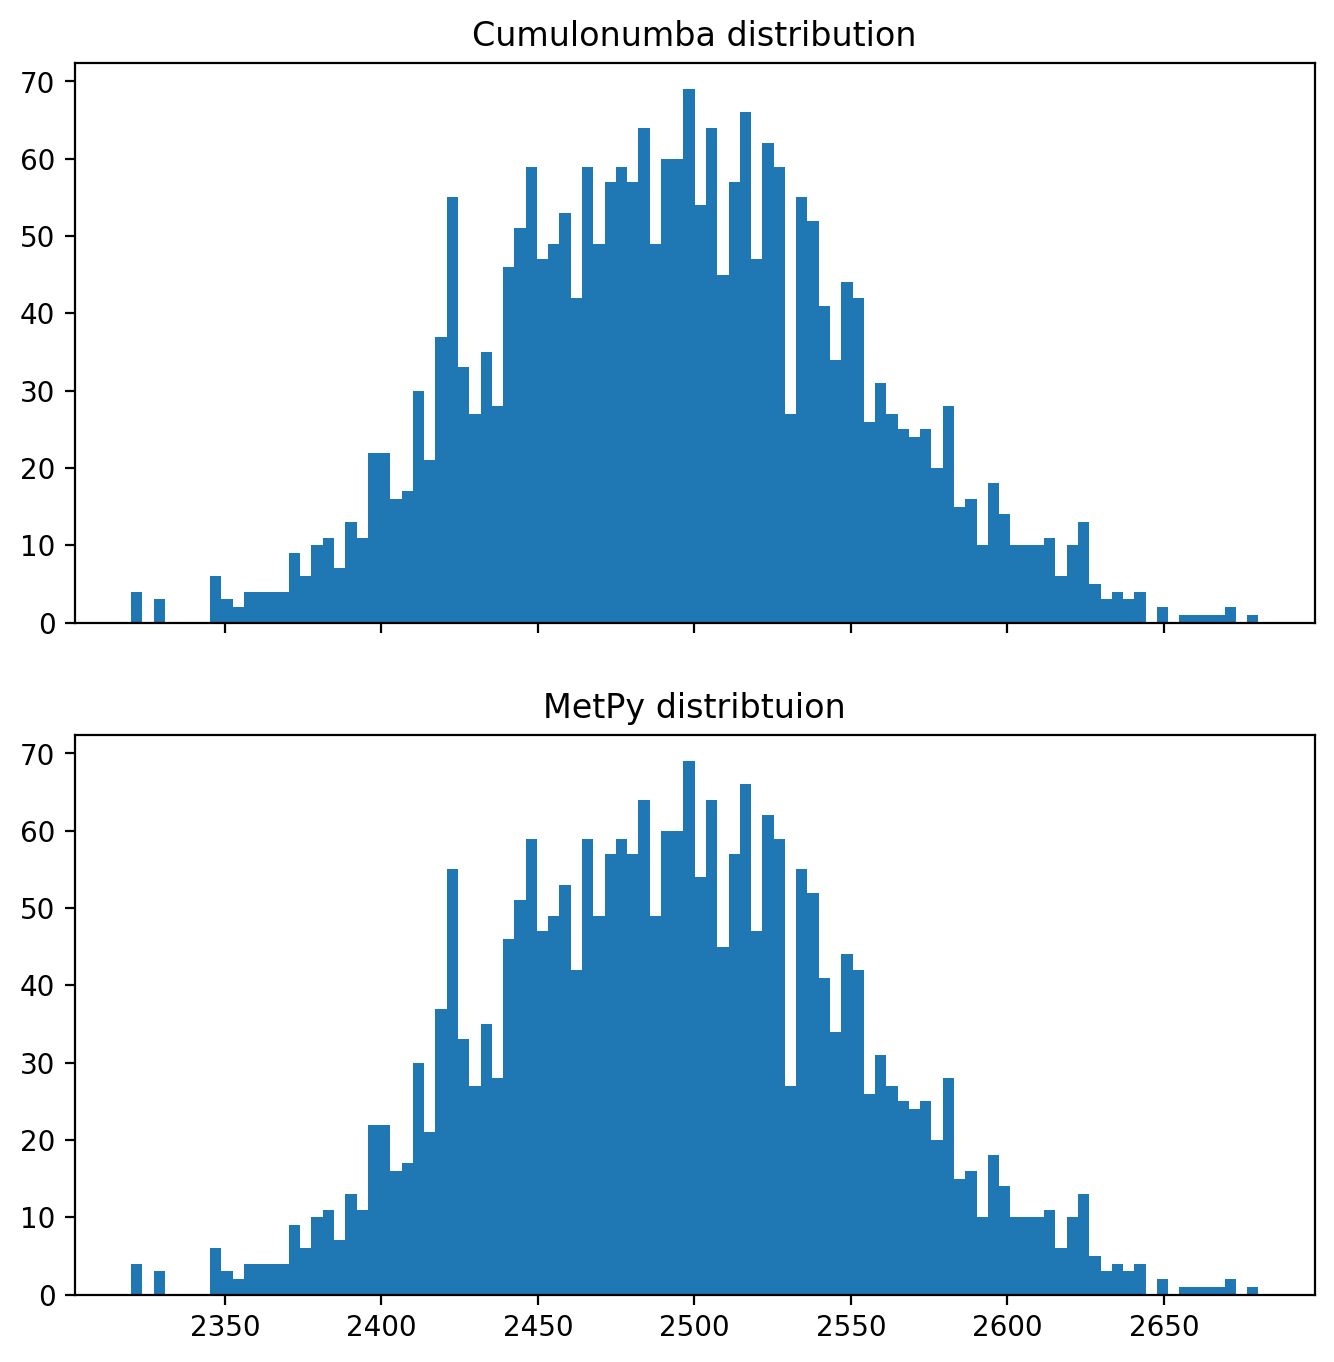

In [11]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax0.hist(cape_cn, 100)
ax0.set_title("Cumulonumba distribution")
ax1.hist(cape_mp, 100)
ax1.set_title("MetPy distribtuion")

plt.show()